<font size = 6>  Задание №2. </font> 

Используя набор данных на листе «Training» (см. Задания_1_2.xlsx) в качестве обучающей выборки, предсказать значения целевой переменной Target для набора данных на листе «Validate».  

Пояснить выбор метода. 

Привести оценки точности и качества предиктивной модели. 

Построить ROC-кривую. 

Назвать три наиболее важных предиктора.

## Библиотеки.

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
import catboost
from catboost import *
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Загрузка данных.

Загрузим тренировочные и тестовые данные и посмотрим на них.

In [260]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [261]:
data = pd.read_excel('Задания_1_2.xlsx', index_col='ID', sheet_name='Training')
print(f"Количество строк и столбцов:{data.shape}")
data.head()

Количество строк и столбцов:(10000, 32)


,Target,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
283,1,0.0,NaN,NaN,10,0,1.02273,1.01608,1.55268,1.15000,30.00000,123.00000,45.54444,3.80000,7.32222,38.22222,3.83333,819.35667,0.0,1.66667,0.0000,0.28560,831.68333,783.81667,171.33333,818.15000,0.62772,0.13333,0.00000,6.41893,0.97122,6.41893
342,0,0.0,30.00000,6.80153,0,0,1.00000,1.65348,1.14852,0.40556,9.00000,78.00000,23.74444,17.97222,0.00000,23.74444,3.83333,316.61667,0.0,0.33333,0.0000,0.00000,195.13889,168.30000,81.00000,NaN,6.32407,0.26667,0.33333,NaN,1.60714,3.44800
631,0,0.0,30.00000,9.60267,0,0,1.00000,0.84143,NaN,0.00000,28.66667,12.66667,15.80000,22.57222,4.58333,11.21667,3.83333,184.49333,0.0,0.00000,0.0000,-2.28400,226.10556,207.41667,110.00000,184.49444,2.25635,0.00000,0.06667,NaN,0.75000,8.08000
1165,0,0.0,30.33333,15.32553,0,0,0.98901,0.88114,NaN,2.68333,61.66667,112.33333,121.02222,175.54444,10.20556,110.81667,3.83333,625.32333,0.0,2.00000,-2.6938,-2.73230,567.53889,441.52778,194.00000,625.32222,2.74469,0.13333,0.40000,13.50400,0.98119,13.50400
1469,0,0.0,28.00000,7.54133,0,0,0.92857,1.21447,0.60138,0.00000,26.00000,89.00000,66.92222,7.52778,0.00000,66.92222,3.83333,53.45000,0.0,0.00000,0.0000,2.42605,154.80556,86.64444,71.66667,53.45000,0.91130,0.46667,0.40000,NaN,0.40171,3.44800


Тут же проверим нет ли дисбаланса классов.

In [262]:
data.Target.value_counts()

1    5000
0    5000
Name: Target, dtype: int64

Дисбаланса классов нет. И тут же делаем вывод, что мы будем иметь дело с бинарной классификацией.

In [263]:
test = pd.read_excel('Задания_1_2.xlsx', index_col='ID', sheet_name='Validate')
print(f"Количество строк и столбцов:{test.shape}")
test.head()

Количество строк и столбцов:(20000, 32)


,Target,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
127,NaN,0.0,30.33333,8.86883,0,0,0.98901,1.01885,1.31226,32.55556,25.00000,52.33333,50.76667,68.01667,33.85000,16.91667,3.83333,95.39333,0.00,6.00000,0.0,0.25075,85.59444,32.45000,41.00000,95.39444,4.64779,0.40000,0.73333,8.256,0.11725,8.256
214,NaN,0.0,30.33333,12.82570,0,0,0.98901,0.96587,0.94475,2.72222,73.33333,753.00000,12.80000,4.75556,2.97778,9.82222,3.83333,239.95000,5.68,2.33333,0.0,-0.65655,809.37778,787.77778,164.66667,239.95000,2.34907,0.00000,0.00000,4.320,1.33333,10.000
542,NaN,0.0,9.00000,5.25643,0,0,0.88889,0.97863,1.68000,0.43333,6.00000,15.00000,0.45000,0.43333,0.00000,0.45000,3.83333,1.26667,0.00,0.33333,0.0,0.00000,26.34444,25.89444,1.33333,1.26667,0.43333,0.13333,0.06667,5.096,1.16688,5.096
674,NaN,0.0,24.33333,NaN,0,0,0.90411,0.88409,0.58490,2.07778,22.66667,32.66667,41.37222,2.43333,16.82778,24.54444,NaN,34.62000,0.00,2.00000,0.0,0.00000,116.31111,73.20000,27.33333,34.62222,0.69722,0.33333,0.13333,4.712,1.80000,4.712
756,NaN,0.0,30.33333,21.90167,0,0,0.98901,1.02636,1.30082,42.82778,49.33333,104.33333,50.64444,86.12778,18.40000,32.24444,3.83333,369.42667,0.00,29.00000,0.0,0.86600,275.16111,201.13889,285.00000,369.42778,1.36109,0.13333,0.13333,21.096,0.00000,21.096


Мы имеем тренирововчный датасет в 10 000 строк и 32 столбца и тестовый датасет в 20 000 строк и 32 столбца. Сопроводительной документации к данным нет, поэтому значение столбцов остается неясным.

## Предварительный анализ.

Тренировочный и тестовый датасет должны обрабатываться вместе. Объединим их.

In [264]:
all_data = pd.concat((data, test))
all_data.shape

(30000, 32)

**Типы данных.**

In [265]:
all_data.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

Все данные имеют тип либо float64, либо int64.

**Описательная статистика.**

In [266]:
all_data.describe()

,Target,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
count,10000.000000,30000.000000,25524.000000,25544.000000,30000.000000,30000.000000,30000.000000,30000.000000,25467.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,25472.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,25475.000000,30000.000000,30000.000000,30000.000000,25454.000000,30000.000000,30000.000000
mean,0.500000,0.895406,26.396750,14.984125,1.395833,0.074800,0.969799,0.993820,0.915077,8.945033,30.779733,58.206644,43.994074,46.454134,9.408956,34.584850,3.917904,313.290094,0.549080,4.293544,-0.037207,-0.296394,301.958484,253.506987,141.908811,317.061991,1.798970,0.161462,0.156746,9.566023,0.990269,11.085065
std,0.500025,3.476101,6.443517,11.846955,4.322380,0.263073,0.171812,0.210290,0.447146,45.295307,28.879679,57.838584,96.128739,113.265962,44.638516,81.033543,1.950761,377.395229,1.813732,13.052003,4.175786,15.497766,323.133992,288.621404,148.638158,382.008798,1.983403,0.167962,0.173950,5.794027,0.514853,7.007248
min,0.000000,0.000000,1.000000,0.723030,0.000000,0.000000,0.048390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,-98.213200,-1697.790650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.800000,0.000000
25%,0.000000,0.000000,25.666670,8.368552,0.000000,0.000000,0.966670,0.923810,0.691730,0.000000,14.000000,23.666670,3.005560,1.938890,0.000000,1.744440,2.366670,69.820002,0.000000,0.000000,0.000000,-1.159063,82.176390,59.873668,44.666670,69.863890,0.622590,0.000000,0.000000,4.712000,0.750493,5.096000
50%,0.500000,0.000000,29.666670,13.149030,0.000000,0.000000,0.989010,0.997590,0.917790,0.433330,23.666670,44.000000,14.438890,12.469445,0.616670,10.161110,4.100000,191.831670,0.000000,0.333330,0.000000,0.000000,202.136110,159.658335,99.666670,193.611110,1.303240,0.133330,0.133330,9.536000,1.000000,9.536000
75%,1.000000,0.000000,30.333330,18.706415,0.000000,0.000000,1.000000,1.044485,1.125485,4.688890,38.666670,76.333330,46.423610,46.133330,4.816670,34.658338,5.566670,411.229165,0.000000,3.000000,0.000000,0.392275,412.401390,344.561747,190.333330,417.013890,2.299233,0.266670,0.266670,12.431453,1.211045,14.624000
max,1.000000,66.666670,30.333330,409.205170,30.000000,1.000000,2.608700,2.858990,3.000000,3313.494440,1435.000000,4215.333330,3112.133330,3469.405560,3076.000000,2553.238890,8.233330,5357.526670,61.082670,406.666670,197.127700,815.507550,5724.961110,4460.672220,2951.000000,5339.972220,29.796630,1.000000,1.000000,96.288000,7.246720,110.954670


Видим, что у всех признаков есть выбросы, кроме P16. Это стоит учесть при выборе модели обучения. Также нужно обратить внимание на то, что значения признаков отличаются до порядка 1000. Значит данные нужно нормализовать.

In [267]:
all_data.nunique()

Target        2
P1           37
P2           89
P3        20833
P4           31
P5            2
P6          914
P7        20226
P8        22010
P9         5481
P10         580
P11         911
P12       13040
P13       12860
P14        5515
P15       11568
P16         242
P17       27378
P18         699
P19         348
P20        4803
P21       18045
P22       25966
P23       26371
P24        2103
P25       22532
P26       21226
P27          44
P28          47
P29        2509
P30       11800
P31        4604
dtype: int64

**Дублированные записи.**

Проверим, есть ли дубликаты записей. Если есть, то удалим их (но не из тестового датасета!).

In [268]:
print(f'Количество дублированных записей в тренировочном датасете {all_data.duplicated().sum()}.')

Количество дублированных записей в тренировочном датасете 0.


**Пропущенные значения.**

In [269]:
miss_cols = []
for col, per in zip(all_data.columns, all_data.isnull().mean()*100):
    if per > 0:
        print(col, per)
        miss_cols.append(col)

Target 66.66666666666666
P2 14.92
P3 14.853333333333332
P8 15.110000000000001
P16 15.093333333333334
P25 15.083333333333334
P29 15.153333333333332


Target в тренировочном датасете не должен иметь пропущенных значений. Проверяем это.

In [270]:
data.Target.isnull().mean()

0.0

In [271]:
test.Target.isnull().mean()

1.0

Теперь посмотрим на распределния признаков, котоые имеют пропуски.

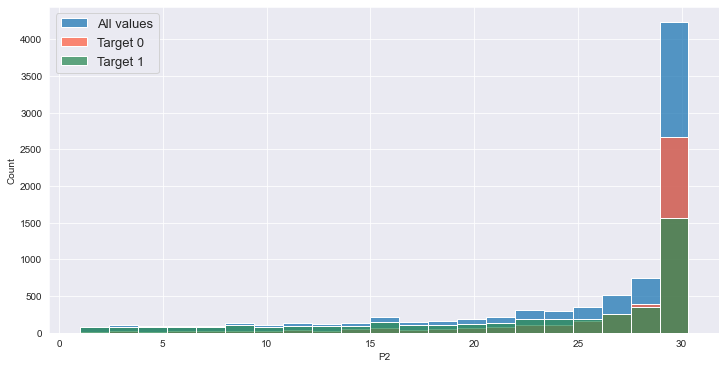

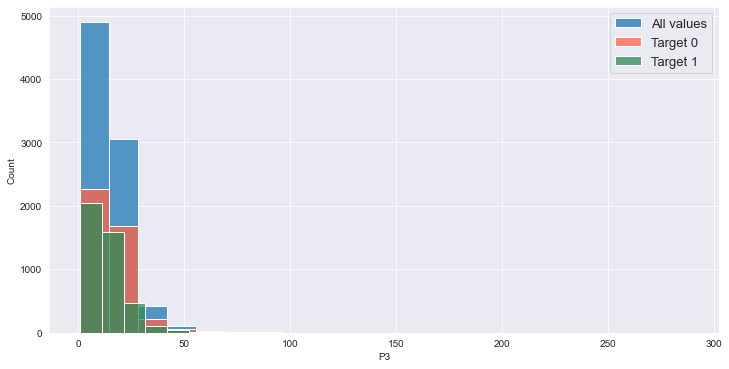

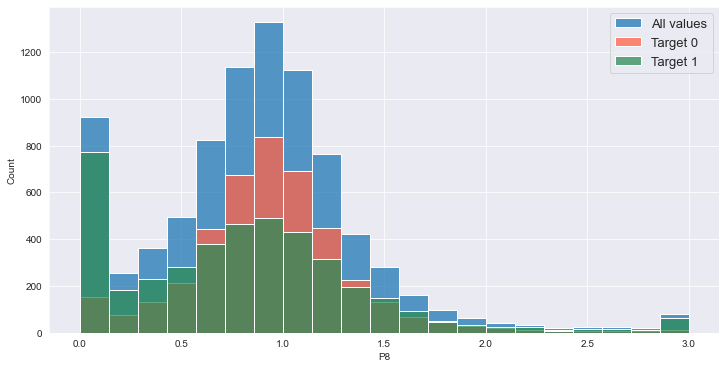

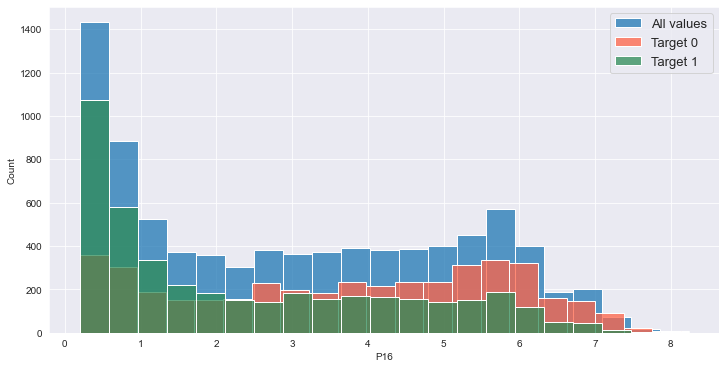

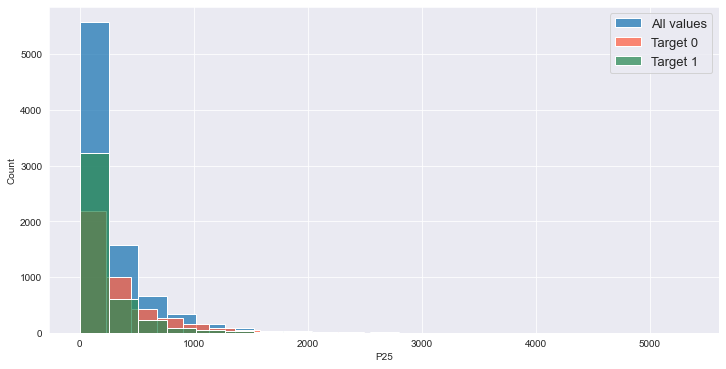

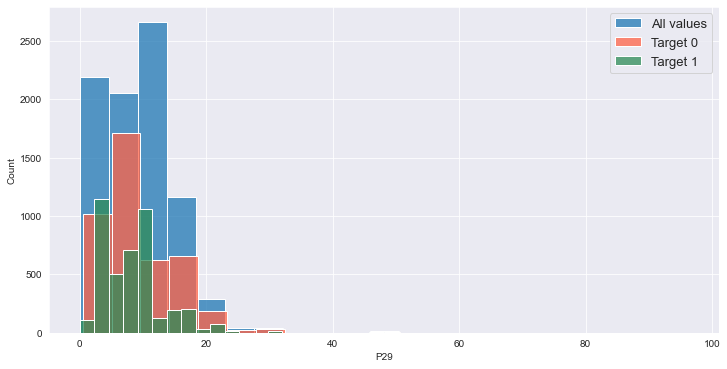

In [272]:
miss_cols.remove('Target')      #удаление колонки Target
sns.set_style('darkgrid')
for col in miss_cols:
    plt.figure(figsize=(12, 6))
    sns.histplot(x = data[col], bins = 21, label='All values')
    sns.histplot(x = data[data['Target']==0][col], bins = 21, label='Target 0', color='tomato')
    sns.histplot(x = data[data['Target']==1][col], bins = 21, label='Target 1', color='seagreen')
    plt.legend(fontsize=13)
    plt.show()

Можно сказать, что формы гистограмм при разных целевых переменных схожи. Все распределемения имеют смещения, так что средним значением пропуски лучше не заменять. Будем использовать медиану.

In [273]:
for col in ['P2', 'P3', 'P8', 'P16', 'P25', 'P29']:
    all_data[col].fillna(all_data[col].median(), inplace = True)

**Неинформативные данные.**

In [274]:
uninform_cols = []
num_rows = len(all_data.index)
for col in all_data.columns:
    top_val_count = all_data[col].value_counts().iloc[0] / num_rows
    if top_val_count > 0.95:
        uninform_cols.append(col)

print(uninform_cols) if uninform_cols != [] else 'Нет неинформативных данных.'

'Нет неинформативных данных.'

## EDA.

Так как нет описания данных, то сложно выдвигать какие-либо гипотизы. Однако мы можем найти коррелирующие признаки.

**Матрица корреляции.**

In [275]:
corr_matrix = all_data.corr(method='pearson')
corr_col = {}
columns = all_data.corr(method='pearson').columns[:-1]
for i in range(len(columns)):
  col = columns[i]
  cols = columns[:(i+1)]  
  corr_list = corr_matrix[col][(i+1):][np.abs(corr_matrix[col][(i+1):])>0.9].index.tolist()
  if corr_list!=[]:
    corr_col[col] = corr_list
corr_col

{'P1': ['P5'], 'P17': ['P25'], 'P22': ['P23']}

In [276]:
all_data.P1.value_counts().head()

0.00000     27756
10.00000      284
12.50000      270
11.11111      261
9.09091       255
Name: P1, dtype: int64

In [277]:
all_data.P5.value_counts().head()

0    27756
1     2244
Name: P5, dtype: int64

In [278]:
all_data = all_data.drop(columns=['P5'])

In [279]:
train_data_len = data.shape[0]
data = all_data[:train_data_len]
test = all_data[train_data_len:]

## Построение модели.

Создадим 3 выборки: тренировочная, валидационная и тестовая.

In [280]:
X = data.drop(columns='Target')
y = data.Target
X_test = test.drop(columns='Target')

In [281]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  stratify=y, 
                                                  test_size=0.2, 
                                                  random_state = 2023
                                                  )

В признаковом пространстве есть выбросы. Основная их часть - это "хвосты". Будем использовать QuantileTransformer, чтобы данные были более равномерными.

In [282]:
quant_transform = QuantileTransformer(n_quantiles=35, random_state=2023)
X_train_transform = quant_transform.fit_transform(X_train)
X_val_transform = quant_transform.transform(X_val)
X_test_transform = quant_transform.transform(X_test)

**Baseline.**

При построении модели будем использовать метод кросс-валидации K-folds.

In [283]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=2023)

Мы решаем задачу *бинарной классификации* (классы сбалансированы). 

Подходы бинарной классификации обычно схожи с моделями логистической регрессии. Также моожно использовать метод опорных векторов и метод градиентного спуска.

Для оценки качества модели будем использовать ROC-AUC (площадь под кривой ошибок). 

*LogisticRegression.*

In [284]:
model_LR = LogisticRegression(random_state=2023)
scores_LR = cross_val_score(model_LR, X_train_transform, y_train, scoring='roc_auc', cv=k_fold, n_jobs=-1)
print('Mean ROC AUC: %.5f' % scores_LR.mean())

Mean ROC AUC: 0.75792


*CatBoostClassifier.*

In [285]:
model_CBC = catboost.CatBoostClassifier(random_state=2023)
scores_CBC = cross_val_score(model_CBC, X_train_transform, y_train, scoring='roc_auc', cv=k_fold, n_jobs=-1)
print('Mean ROC AUC: %.5f' % scores_CBC.mean())

Mean ROC AUC: 0.76564


Модель CatBoost показала немного лучший результат, так что будем использовать её.

Посмотрим на получившиеся метрики и построим ROC-AUC кривую.

In [286]:
baseline_model = catboost.CatBoostClassifier(random_state=2023)
baseline_model.fit(X_train_transform, y_train, verbose=False, plot=False)
y_base_pred = baseline_model.predict(X_val_transform)
y_base_scor = baseline_model.predict_proba(X_val_transform)[:,1]

In [287]:
print(f'accuracy = {accuracy_score(y_val, y_base_pred)}')
print(f'precision = {precision_score(y_val, y_base_pred)}')
print(f'recall = {recall_score(y_val, y_base_pred)}')
print(f'f1= {f1_score(y_val, y_base_pred)}')
print(f'roc-auc = {roc_auc_score(y_val, y_base_scor)}')

accuracy = 0.688
precision = 0.6865079365079365
recall = 0.692
f1= 0.6892430278884462
roc-auc = 0.749713


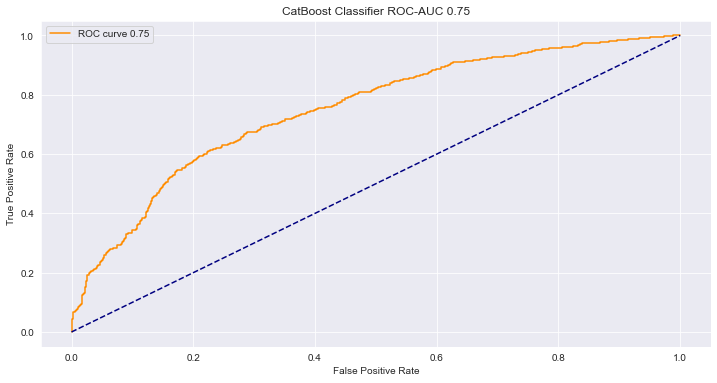

In [288]:
fp_base, tp_base, _ = roc_curve(y_val, y_base_scor)
auc_base = auc(fp_base, tp_base)

plt.figure(figsize=(12,6))
plt.plot(fp_base, tp_base, color='darkorange', label=f'ROC curve {round(auc_base, 3)}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'CatBoost Classifier ROC-AUC {round(auc_base, 3)}')
plt.legend()
plt.show();

**Подбор параметров модели.**

In [ ]:
CV_model = GridSearchCV(estimator=catboost.CatBoostClassifier(random_state=2023),                        
                        param_grid={'iterations':[200, 300, 500, 1000],
                                    'depth':[3, 7],
                                    'learning_rate':[0.01, 0.1, 0.2, 0.25],
                                    'l2_leaf_reg':[0.01, 0.1, 1, 2, 10]
                                    },
                        cv=5, 
                        scoring='roc_auc',
                        n_jobs=-1)
CV_model.fit(X_train_transform, y_train)

In [290]:
print(CV_model.best_params_)

{'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 2, 'learning_rate': 0.01}


In [291]:
best_params = CV_model.best_params_

In [292]:
model = catboost.CatBoostClassifier(**best_params, random_state=2023)
model.fit(X_train_transform, y_train, verbose=False, plot=False)
y_pred = model.predict(X_val_transform)
y_scor = model.predict_proba(X_val_transform)[:,1]

In [293]:
print(f'accuracy = {accuracy_score(y_val, y_pred)}')
print(f'precision = {precision_score(y_val, y_pred)}')
print(f'recall = {recall_score(y_val, y_pred)}')
print(f'f1= {f1_score(y_val, y_pred)}')
print(f'roc-auc = {roc_auc_score(y_val, y_scor)}')

accuracy = 0.6895
precision = 0.6863323500491643
recall = 0.698
f1= 0.6921170054536441
roc-auc = 0.75008


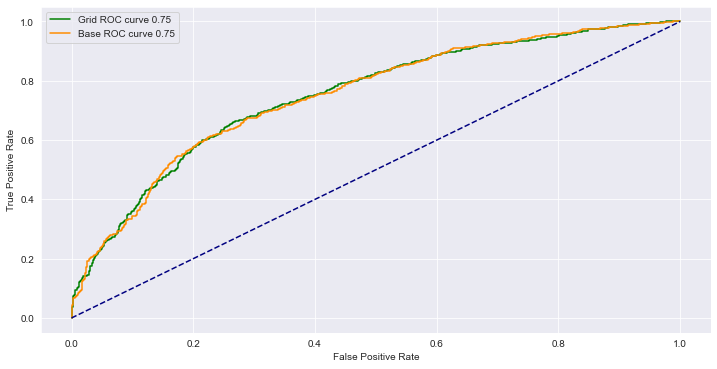

In [294]:
fp, tp, _ = roc_curve(y_val, y_scor)
auc_n = auc(fp, tp)

plt.figure(figsize=(12,6))
plt.plot(fp, tp, color='g', label=f'Grid ROC curve {round(auc_n, 3)}')
plt.plot(fp_base, tp_base, color='darkorange', label=f'Base ROC curve {round(auc_base, 3)}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

После подбора параметров, модель стала работать лучше, хотя и не на много. Так что финальная модель  - это CatBoostClassifier с параметрами:
* 'depth' = 7, 
* 'iterations' = 1000, 
* 'l2_leaf_reg' = 2, 
* 'learning_rate' = 0.01.

Оценки для данной модели:
* accuracy = 0.6895
* precision = 0.6863323500491643
* recall = 0.698
* f1= 0.6921170054536441
* roc-auc = 0.75008

**Анализ важный признаков.**

Для определения важности признаков, будем использовать shap.

In [295]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train_transform, y_train))

In [296]:
feature_names = X.columns

rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

Выведим топ 3 важных признаков.

In [297]:
shap_importance[:3]

,col_name,feature_importance_vals
14,P16,0.314024
8,P10,0.203953
21,P23,0.187523


Самые важные признаки - это P16, P10, P23.

In [298]:
imp_cols = shap_importance[shap_importance.feature_importance_vals >=0.02].index.tolist()

In [299]:
X_train_imp = X_train_transform[:, imp_cols]
X_val_imp = X_val_transform[:, imp_cols]

In [300]:
model_imp = catboost.CatBoostClassifier(**best_params, random_state=2023)
model_imp.fit(X_train_imp, y_train, verbose=False, plot=False)
y_pred_imp = model_imp.predict(X_val_imp)
y_scor_imp = model_imp.predict_proba(X_val_imp)[:,1]

In [301]:
print(f'accuracy = {accuracy_score(y_val, y_pred_imp)}')
print(f'precision = {precision_score(y_val, y_pred_imp)}')
print(f'recall = {recall_score(y_val, y_pred_imp)}')
print(f'f1= {f1_score(y_val, y_pred_imp)}')
print(f'roc-auc = {roc_auc_score(y_val, y_scor_imp)}')

accuracy = 0.6915
precision = 0.6920762286860582
recall = 0.69
f1= 0.6910365548322484
roc-auc = 0.751234


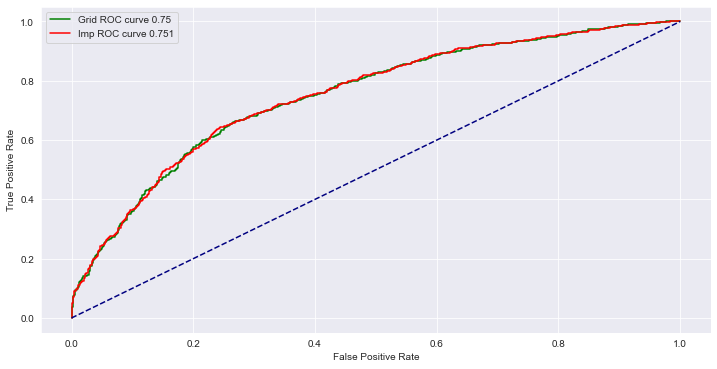

In [302]:
fp_imp, tp_imp, _ = roc_curve(y_val, y_scor_imp)
auc_imp = auc(fp_imp, tp_imp)

plt.figure(figsize=(12,6))
plt.plot(fp, tp, color='g', label=f'Grid ROC curve {round(auc_n, 3)}')
plt.plot(fp_imp, tp_imp, color='r', label=f'Imp ROC curve {round(auc_imp, 3)}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

Метрики чуть улучшились после того, как мы отбросили часть неважных признаков.

## Предсказания.

Итогавая модель CatBoostClassifier с параметрами:
* 'depth' = 7, 
* 'iterations' = 1000, 
* 'l2_leaf_reg' = 1, 
* 'learning_rate' = 0.01.

При обучении будем использовать только параметры с показателем важности >= 0.02.

In [303]:
X_transform = quant_transform.fit_transform(X)
X_test_transform = quant_transform.transform(X_test)

In [304]:
X_transform_imp = X_transform[:, imp_cols]
X_test_transform_imp = X_test_transform[:, imp_cols]

In [305]:
model = catboost.CatBoostClassifier(**best_params, random_state=2023)
model.fit(X_transform_imp, y, verbose=False, plot=False)
y_pred = model.predict(X_test_transform_imp)

In [306]:
y_exel = pd.DataFrame(data = {'ID':X_test.index, 'Target':y_pred})
y_exel.head()

,ID,Target
0,127,1.0
1,214,0.0
2,542,1.0
3,674,1.0
4,756,0.0


In [ ]:
y_exel.to_excel('task_2.xlsx')